In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [115]:
# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

In [121]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [123]:
# Hyperparameters
batch_size = 128
image_size = 64
nz = 100  
ngf = 64  
ndf = 64  
num_epochs = 11
lr = 0.0002
beta1 = 0.5

In [125]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalize the images to [-1, 1]
])

In [127]:
# Load the dataset
dataset = datasets.ImageFolder(root='cats', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

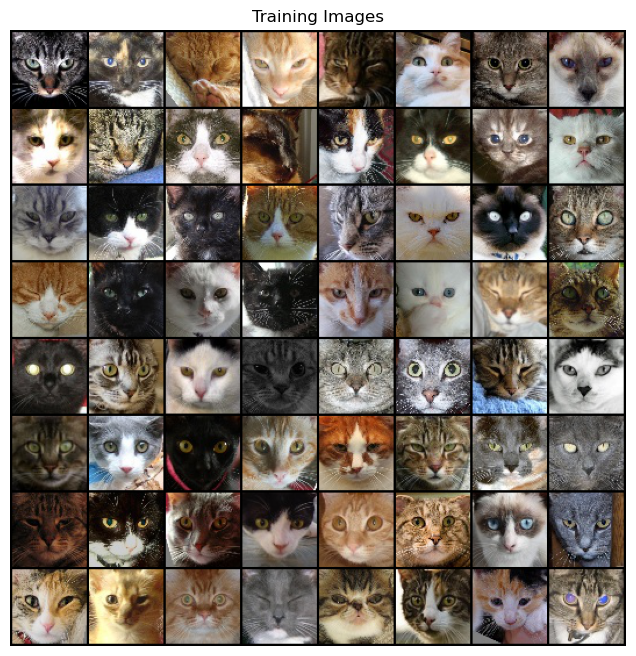

In [131]:
# Display some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [133]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [135]:
# Generator with added Dropout layers
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [137]:
# Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [139]:
# Instantiate the models
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [141]:
# Loss function
criterion = nn.BCELoss()

In [143]:
# Create batch of latent vectors for visualization
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [145]:
# Establish convention for real and fake labels during training
real_label = 0.9 
fake_label = 0.1

In [147]:
# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [149]:
# Training Loop with added logging and enhancements
img_list = []
G_losses = []
D_losses = []
iters = 0

In [153]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Train with real batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    print(f"Epoch {epoch+1}/{num_epochs}, Loss_D: {errD.item()}, Loss_G: {errG.item()}, D(x): {D_x}, D(G(z)): {D_G_z1}/{D_G_z2}")

Starting Training Loop...
Epoch 1/11, Loss_D: 1.0026276111602783, Loss_G: 3.5118229389190674, D(x): 0.6799013018608093, D(G(z)): 0.29700037837028503/0.052607208490371704
Epoch 2/11, Loss_D: 0.7394027709960938, Loss_G: 4.142624855041504, D(x): 0.7837364077568054, D(G(z)): 0.1623460054397583/0.010888065211474895
Epoch 3/11, Loss_D: 0.872107744216919, Loss_G: 2.125044107437134, D(x): 0.6678001880645752, D(G(z)): 0.17572492361068726/0.13812415301799774
Epoch 4/11, Loss_D: 0.9568590521812439, Loss_G: 6.925788879394531, D(x): 0.8089675903320312, D(G(z)): 0.3753294050693512/0.0005683992640115321
Epoch 5/11, Loss_D: 1.081559181213379, Loss_G: 1.3075028657913208, D(x): 0.6000530123710632, D(G(z)): 0.13157717883586884/0.27286073565483093
Epoch 6/11, Loss_D: 0.8831779956817627, Loss_G: 8.088618278503418, D(x): 0.8903678059577942, D(G(z)): 0.36157166957855225/0.0006585905211977661
Epoch 7/11, Loss_D: 1.9897441864013672, Loss_G: 12.151345252990723, D(x): 0.7132909297943115, D(G(z)): 0.7330560088157

In [155]:
# Save the trained models
torch.save(netG.state_dict(), "generator.pth")
torch.save(netD.state_dict(), "discriminator.pth")

In [157]:
# Generate images after training
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()

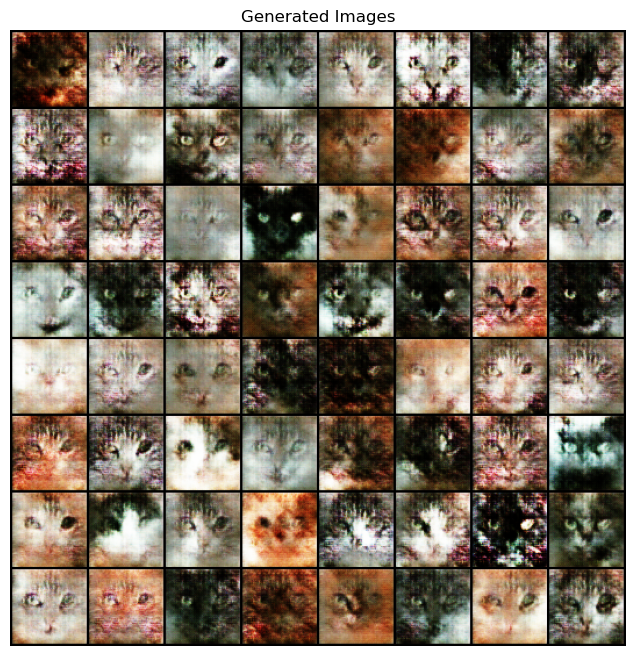

In [159]:
# Display the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()

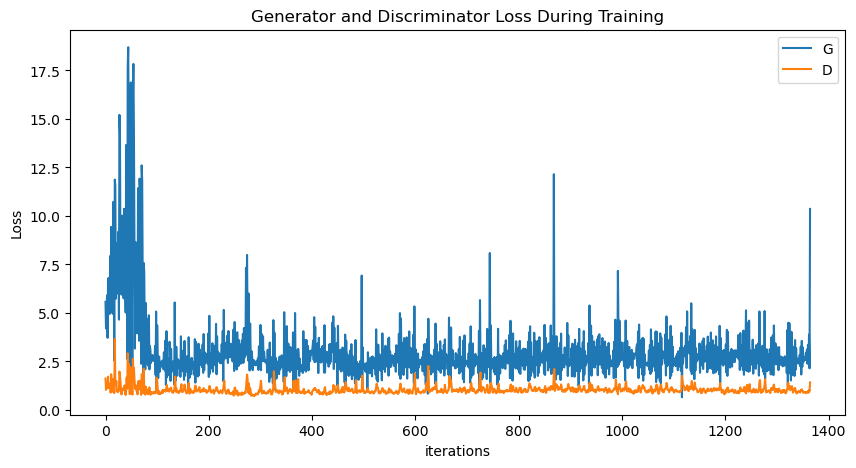

In [161]:
# Plot the losses for generator and discriminator
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()